In [28]:
###IMPORTING THE LIBRARIES
from pyspark.ml.regression import GBTRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum,avg,round,monotonically_increasing_id,lit,filter
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
#CREATING THE SESSION
sesion=SparkSession.builder.appName("sesion").getOrCreate()

In [2]:
df=sesion.read.csv("cars_spark.csv",header=True,sep=",")
df.show(5,truncate=False)

+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-----+
|year|manufacturer|condition|cylinders  |fuel  |title_status|transmission|drive|size     |type       |paint_color|price|
+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-----+
|2009|chevrolet   |good     |8 cylinders|gas   |clean       |automatic   |rwd  |full-size|SUV        |white      |9000 |
|2002|gmc         |good     |8 cylinders|gas   |clean       |automatic   |4wd  |NULL     |pickup     |white      |6000 |
|2007|pontiac     |excellent|4 cylinders|gas   |clean       |automatic   |fwd  |compact  |convertible|red        |7000 |
|2012|chevrolet   |excellent|8 cylinders|diesel|clean       |automatic   |4wd  |full-size|pickup     |silver     |37000|
|2003|NULL        |fair     |8 cylinders|gas   |clean       |automatic   |4wd  |NULL     |pickup     |silver     |3700 |
+----+------------+---------+---

In [3]:
#FINDING THE SHAPE OF THE DATA
rows=df.count()
columns=len(df.columns)
print(f"rows: {rows} | columns: {columns}")

rows: 434542 | columns: 12


In [4]:
#ANALYZING THE DATA
df.printSchema()

root
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- price: string (nullable = true)



In [5]:
##FINDING THE % OF NULL VALUES
from pyspark.sql import functions as F

# Calcular el número total de filas
total_rows = df.count()

# Crear una lista de expresiones para calcular el porcentaje de valores nulos
null_percentage_expr = [
    round((F.sum(F.col(c).isNull().cast("int")) / total_rows * 100), 1).alias(c) 
    for c in df.columns
]

# Aplicar las expresiones y obtener los porcentajes de valores nulos
null_percentages_df = df.agg(*null_percentage_expr)

# Convertir el DataFrame en formato de dos columnas (Columna, Porcentaje de Nulos)
null_percentages = null_percentages_df.select(F.explode(F.array([
    F.struct(F.lit(c).alias("Column"), F.col(c).alias("Null_Percentage")) 
    for c in df.columns
]))).select("col.*")

# Ordenar el resultado en orden descendente por el porcentaje de valores nulos
null_percentages.orderBy(F.col("Null_Percentage").desc()).show()


+------------+---------------+
|      Column|Null_Percentage|
+------------+---------------+
|        size|           58.1|
|   condition|           36.9|
|   cylinders|           28.3|
| paint_color|           19.7|
|       drive|           13.3|
|        type|           11.6|
|manufacturer|            3.6|
|transmission|            1.0|
|        fuel|            0.8|
|title_status|            0.7|
|        year|            0.0|
|       price|            0.0|
+------------+---------------+



In [6]:
# Dropping all the rows with the word "Other" in order to try to not confuse the machine learning model

filtered_df = df.filter(~(
    (F.col("manufacturer") == "other") | 
    (F.col("condition") == "other") | 
    (F.col("cylinders") == "other") | 
    (F.col("fuel") == "other") | 
    (F.col("title_status") == "other") | 
    (F.col("transmission") == "other") | 
    (F.col("drive") == "other") | 
    (F.col("size") == "other") | 
    (F.col("type") == "other") | 
    (F.col("paint_color") == "other")
))

# Asignar el DataFrame filtrado al original si deseas sobrescribirlo
df = filtered_df
df.show(5,truncate=False)

+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-----+
|year|manufacturer|condition|cylinders  |fuel  |title_status|transmission|drive|size     |type       |paint_color|price|
+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-----+
|2009|chevrolet   |good     |8 cylinders|gas   |clean       |automatic   |rwd  |full-size|SUV        |white      |9000 |
|2007|pontiac     |excellent|4 cylinders|gas   |clean       |automatic   |fwd  |compact  |convertible|red        |7000 |
|2012|chevrolet   |excellent|8 cylinders|diesel|clean       |automatic   |4wd  |full-size|pickup     |silver     |37000|
|2004|toyota      |good     |4 cylinders|gas   |clean       |automatic   |fwd  |mid-size |sedan      |brown      |3795 |
|2010|cadillac    |good     |8 cylinders|gas   |clean       |automatic   |fwd  |mid-size |SUV        |white      |9700 |
+----+------------+---------+---

In [7]:
#FINDING THE NEW SHAPE OF THE DATA
rows=df.count()
columns=len(df.columns)
print(f"rows: {rows} | columns: {columns}")

rows: 128235 | columns: 12


In [8]:
#Finding the categorical features and the amount of different values the have
categorical_columns = [col for col, dtype in df.dtypes if dtype == 'string']

#Finding the null values in the categorical features
for col in categorical_columns:
    distinct_count = df.select(col).distinct().count()
    print(f"The feature {col} contains {distinct_count} distinct values")

The feature year contains 100 distinct values
The feature manufacturer contains 39 distinct values
The feature condition contains 6 distinct values
The feature cylinders contains 7 distinct values
The feature fuel contains 4 distinct values
The feature title_status contains 6 distinct values
The feature transmission contains 2 distinct values
The feature drive contains 3 distinct values
The feature size contains 4 distinct values
The feature type contains 12 distinct values
The feature paint_color contains 12 distinct values
The feature price contains 5092 distinct values


In [9]:
df.dtypes

[('year', 'string'),
 ('manufacturer', 'string'),
 ('condition', 'string'),
 ('cylinders', 'string'),
 ('fuel', 'string'),
 ('title_status', 'string'),
 ('transmission', 'string'),
 ('drive', 'string'),
 ('size', 'string'),
 ('type', 'string'),
 ('paint_color', 'string'),
 ('price', 'string')]

In [10]:
##Since the column "price" is considered a string,it needs to be changed to a float.Additionally,"year" will be converted to int
from pyspark.sql.functions import col
df=df.withColumn("price",col("price").cast("FLOAT")).withColumn("year",col("year").cast("INT"))
df.dtypes

[('year', 'int'),
 ('manufacturer', 'string'),
 ('condition', 'string'),
 ('cylinders', 'string'),
 ('fuel', 'string'),
 ('title_status', 'string'),
 ('transmission', 'string'),
 ('drive', 'string'),
 ('size', 'string'),
 ('type', 'string'),
 ('paint_color', 'string'),
 ('price', 'float')]

In [58]:
categorical_columns = [col for col, dtype in df.dtypes if dtype == 'string']
categorical_columns

['manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

In [12]:
#Filling the null values with the mode of each feature
for col_name in categorical_columns:
    mode_value = df.groupBy(col_name).count().orderBy(F.desc("count")).first()[0]
    df = df.withColumn(col_name, F.when(F.col(col_name).isNull(), mode_value).otherwise(F.col(col_name)))
df.show(5,truncate=False)

+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-------+
|year|manufacturer|condition|cylinders  |fuel  |title_status|transmission|drive|size     |type       |paint_color|price  |
+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-------+
|2009|chevrolet   |good     |8 cylinders|gas   |clean       |automatic   |rwd  |full-size|SUV        |white      |9000.0 |
|2007|pontiac     |excellent|4 cylinders|gas   |clean       |automatic   |fwd  |compact  |convertible|red        |7000.0 |
|2012|chevrolet   |excellent|8 cylinders|diesel|clean       |automatic   |4wd  |full-size|pickup     |silver     |37000.0|
|2004|toyota      |good     |4 cylinders|gas   |clean       |automatic   |fwd  |mid-size |sedan      |brown      |3795.0 |
|2010|cadillac    |good     |8 cylinders|gas   |clean       |automatic   |fwd  |mid-size |SUV        |white      |9700.0 |
+----+----------

In [59]:
##CHECKING IF THERE IS STILL NULL VALUES
from pyspark.sql import functions as F

# Calcular el número total de filas
total_rows = df.count()

# Crear una lista de expresiones para calcular el porcentaje de valores nulos
null_percentage_expr = [
    round((F.sum(F.col(c).isNull().cast("int")) / total_rows * 100), 1).alias(c) 
    for c in df.columns
]

# Aplicar las expresiones y obtener los porcentajes de valores nulos
null_percentages_df = df.agg(*null_percentage_expr)

# Convertir el DataFrame en formato de dos columnas (Columna, Porcentaje de Nulos)
null_percentages = null_percentages_df.select(F.explode(F.array([
    F.struct(F.lit(c).alias("Column"), F.col(c).alias("Null_Percentage")) 
    for c in df.columns
]))).select("col.*")

# Ordenar el resultado en orden descendente por el porcentaje de valores nulos
null_percentages.orderBy(F.col("Null_Percentage").desc()).show()

+------------+---------------+
|      Column|Null_Percentage|
+------------+---------------+
|        year|            0.0|
|manufacturer|            0.0|
|   condition|            0.0|
|   cylinders|            0.0|
|        fuel|            0.0|
|title_status|            0.0|
|transmission|            0.0|
|       drive|            0.0|
|        size|            0.0|
|        type|            0.0|
| paint_color|            0.0|
|       price|            0.0|
+------------+---------------+



In [69]:
df.columns

['year',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'price']

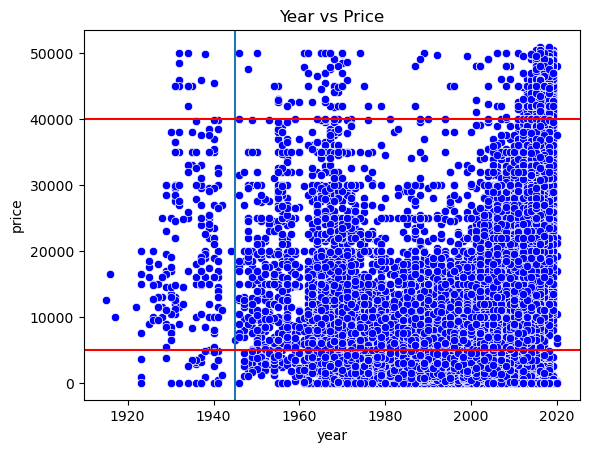

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converting the data to a pandas dataframe
pandas_df = df.toPandas()

# Create the scatter plot
sns.scatterplot(data=pandas_df, x="year", y="price", color="blue")
plt.axvline(1945)
plt.axhline(5000, color="red")
plt.axhline(40000, color="red")
plt.title("Year vs Price")
plt.show()

In [61]:
#The model will work better with "prices" between 5000 and 40000 and a "year" greater than 1945

# Filter the DataFrame based on price and year conditions
df = df.filter((F.col("price").between(5000, 40000)) & (F.col("year") > 1945))

# Show the first few rows of the filtered DataFrame

df.show(5,truncate=False)

+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-------+
|year|manufacturer|condition|cylinders  |fuel  |title_status|transmission|drive|size     |type       |paint_color|price  |
+----+------------+---------+-----------+------+------------+------------+-----+---------+-----------+-----------+-------+
|2009|chevrolet   |good     |8 cylinders|gas   |clean       |automatic   |rwd  |full-size|SUV        |white      |9000.0 |
|2007|pontiac     |excellent|4 cylinders|gas   |clean       |automatic   |fwd  |compact  |convertible|red        |7000.0 |
|2012|chevrolet   |excellent|8 cylinders|diesel|clean       |automatic   |4wd  |full-size|pickup     |silver     |37000.0|
|2010|cadillac    |good     |8 cylinders|gas   |clean       |automatic   |fwd  |mid-size |SUV        |white      |9700.0 |
|2011|gmc         |excellent|6 cylinders|gas   |clean       |automatic   |fwd  |mid-size |SUV        |white      |11995.0|
+----+----------

## CREATING THE MODEL

In [70]:
categorical_columns

['manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

In [62]:
##Convert categorical columns to numerical
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_columns]

# Creating a feature vector
feature_columns = ['year'] + [col+"_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Creating a  pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

In [63]:
# Applying the pipeline
data_prepared = pipeline.fit(df).transform(df)

#Splitting the data in train and test
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

In [23]:
# Creating the Gradient Boosting Regressor model
gbt = GBTRegressor(featuresCol="features", labelCol="price", maxIter=100)

# Training the model
model = gbt.fit(train_data)

In [48]:
# Making predictions
predictions = model.transform(test_data)

# Evaluating the model for R2, RMSE, and MAE
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared (R2) on test data = {r2}")

evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

R-squared (R2) on test data = 0.7479726187521283
Root Mean Squared Error (RMSE) on test data = 4003.307168218714
Mean Absolute Error (MAE) on test data = 2840.5535881319624


In [86]:
###COMPARING THE ORIGINAL DATA WITH THE DATA OBTAINED FROM DE ML MODEL
predictions.select(col("price").alias("REAL PRICE"), round(col("prediction")).alias("PREDICTION")).show()

+----------+----------+
|REAL PRICE|PREDICTION|
+----------+----------+
|    9650.0|   11364.0|
|   15900.0|   14015.0|
|   16000.0|    8366.0|
|    9700.0|   12454.0|
|   19500.0|   22351.0|
|   18000.0|   14617.0|
|   23500.0|   19382.0|
|   38000.0|   16020.0|
|   25000.0|   15461.0|
|   18500.0|   13433.0|
|   34000.0|   15692.0|
|    5500.0|    6928.0|
|   24995.0|   15889.0|
|    6750.0|   13026.0|
|    8000.0|    9795.0|
|   16500.0|   13026.0|
|   16000.0|   21537.0|
|    5500.0|    9708.0|
|    5500.0|    9051.0|
|   25250.0|   18417.0|
+----------+----------+
only showing top 20 rows



In [88]:
##HYPERPARAMETER TUNING
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Createa parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [9, 10]) \
     .addGrid(gbt.maxIter, [99, 100]) \
    .build()

# Create a cross-validator
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(labelCol="price", metricName="rmse"),
                    numFolds=3)

# Fit the model using cross-validation
cv_model = cv.fit(train_data)

# Make predictions on the test data
best_predictions = cv_model.transform(test_data)

# Evaluate the best model using multiple metrics
evaluator = RegressionEvaluator(labelCol="price")
metrics = ["rmse", "mse", "mae", "r2"]
for metric in metrics:
    result = evaluator.evaluate(best_predictions, {evaluator.metricName: metric})
    print(f"{metric}: {result}")

rmse: 3844.564717355897
mse: 14780677.865937827
mae: 2644.756516648394
r2: 0.767563541148599


In [90]:
###COMPARING THE ORIGINAL DATA WITH THE DATA OBTAINED FROM DE ML MODEL HYPERTUNED
best_predictions.select(col("price").alias("REAL PRICE"), round(col("prediction")).alias("PREDICTION")).show()

+----------+----------+
|REAL PRICE|PREDICTION|
+----------+----------+
|    9650.0|   14643.0|
|   15900.0|   12508.0|
|   16000.0|   12528.0|
|    9700.0|    9822.0|
|   19500.0|   23298.0|
|   18000.0|   14243.0|
|   23500.0|   20371.0|
|   38000.0|   18851.0|
|   25000.0|   12654.0|
|   18500.0|   12126.0|
|   34000.0|   20304.0|
|    5500.0|   10068.0|
|   24995.0|   15990.0|
|    6750.0|    9590.0|
|    8000.0|    9621.0|
|   16500.0|    9590.0|
|   16000.0|   14130.0|
|    5500.0|    9885.0|
|    5500.0|   11389.0|
|   25250.0|   19233.0|
+----------+----------+
only showing top 20 rows

